### DL-model

Перейдём к этапу реализации следующих моделей:
-  TS-CP^2 model
-  ALACPD model


In [8]:
# !pip install ruptures
# !pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt


from scipy.stats import lognorm

import os

import yfinance as yf
import requests

In [3]:
# Чтение данных из препроцессинга
crypto_values = pd.read_csv("returns_crypto.csv")
crypto_values['Date'] = pd.to_datetime(crypto_values.Date).dt.date
crypto_values.head()

,Unnamed: 0,BTC-USD,ETH-USD,USDT-USD,BNB-USD,XRP-USD,DOGE-USD,ADA-USD,TRX-USD,LINK-USD,...,TRAC-USD,SC-USD,ELF-USD,QTUM-USD,BAT-USD,LRC-USD,DASH-USD,DCR-USD,GAS-USD,Date
0,0,-0.046991,-0.068333,-0.001158,-0.010225,-0.068094,-0.044836,-0.081062,-0.099265,-0.130579,...,-0.116799,-0.109805,-0.121305,-0.057361,-0.108823,-0.126726,-0.039344,-0.092243,-0.070334,2018-06-12
1,1,-0.035316,-0.038944,0.002758,-0.041842,-0.050219,-0.088054,-0.037080,-0.055682,-0.061714,...,-0.096486,-0.060820,-0.047805,-0.056788,-0.063299,-0.032789,-0.058051,-0.002946,-0.069776,2018-06-13
2,2,0.051253,0.088479,0.000418,0.020988,0.049831,0.045083,0.074603,0.093516,0.118578,...,0.246639,0.170375,0.045171,0.048935,0.125883,0.079084,0.090922,0.148690,0.085001,2018-06-14
3,3,-0.032773,-0.055293,0.002988,0.010258,-0.042043,-0.014606,-0.055855,-0.056080,-0.068373,...,-0.051877,-0.079005,-0.012008,-0.042384,0.074454,-0.051358,-0.038249,-0.082695,-0.075215,2018-06-15
4,4,0.014494,0.017593,-0.002691,0.050578,-0.005436,-0.002068,0.001321,0.008048,-0.006866,...,0.011107,-0.017341,0.033364,0.007297,0.024911,0.042775,0.031450,-0.008604,0.017073,2018-06-16


### TS-CP^2 model

In [95]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Conv1D, Add, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Класс для реализации TCN
class TemporalBlock(tf.keras.layers.Layer):
    def __init__(self, n_outputs, kernel_size, strides, dilation_rate, padding, dropout_rate=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = Conv1D(filters=n_outputs, kernel_size=kernel_size, strides=strides, padding=padding, dilation_rate=dilation_rate)
        self.conv2 = Conv1D(filters=n_outputs, kernel_size=kernel_size, strides=strides, padding=padding, dilation_rate=dilation_rate)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        self.relu = Activation('relu')
        self.add = Add()

    def call(self, x, training=None):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.dropout(out, training=training)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.dropout(out, training=training)
        out = self.add([x, out])
        return out

class TCN(tf.keras.Model):
    def __init__(self, num_channels, kernel_size=2, dropout_rate=0.2):
        super(TCN, self).__init__()
        self.layers_list = []
        for i, num_channels in enumerate(num_channels):
            dilation_rate = 2 ** i
            self.layers_list.append(TemporalBlock(num_channels, kernel_size, strides=1, dilation_rate=dilation_rate, padding='causal', dropout_rate=dropout_rate))
    
    def call(self, x, training=None):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x

# Функции для вычисления сходства и потерь
from tensorflow.keras import backend as K

cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)

def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return -v

def _cosine_simililarity_dim2(x, y):
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return -v

def contrastive_loss_fn(history, future, similarity, temperature=0.1):
    sim = similarity(history, future)
    loss = tf.reduce_mean(-tf.math.log(tf.exp(sim / temperature)))
    mean_sim = tf.reduce_mean(sim)
    return loss, mean_sim

@tf.function
def train_step(x, model, optimizer, similarity_fn, loss_fn, temperature=0.1):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss, pos_sim = loss_fn(x, y_pred, similarity_fn, temperature)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, pos_sim

def train_model(model, train_data, similarity_fn, loss_fn, epochs=100, batch_size=64, learning_rate=1e-4, temperature=0.1):
    optimizer = Adam(learning_rate=learning_rate)
    history = []

    num_batches = (len(train_data) // batch_size) * batch_size

    for epoch in tqdm(range(epochs), desc="Training"):
        epoch_loss = 0
        for start in range(0, num_batches, batch_size):
            batch = train_data[start:start+batch_size]
            if batch.shape[1:] != (100, 1):
                continue
            loss, pos_sim = train_step(batch, model, optimizer, similarity_fn, loss_fn, temperature)
            epoch_loss += loss.numpy()
        history.append(epoch_loss / (num_batches // batch_size))

    plt.figure(figsize=(10, 5))
    plt.plot(history, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def detect_change_points(data, model, window_size=100, threshold=0.2):
    data_length = len(data)
    change_points = []
    stats = []

    for i in range(window_size, data_length - window_size):
        window = data[i-window_size:i+window_size]
        if window.shape[0] == window_size:
            window = window.reshape(1, -1, 1)
            pred = model.predict(window)
            stats.append(pred[0][window_size // 2])
            if pred[0][window_size // 2] > threshold:
                change_points.append(i)

    print(f"Stats length: {len(stats)}")
    print(f"Stats: {stats}")

    if len(stats) > 0:
        plt.figure(figsize=(15, 8))
        plt.plot(data, label='Real Data', linewidth=2)
        plt.plot(range(window_size, data_length - window_size), stats, label='Predicted Statistics', linestyle='--')
        for cp in change_points:
            plt.axvline(cp, color='red', linestyle='--', alpha=0.5, label='Detected Change Point' if cp == change_points[0] else "")
        plt.title('Change Point Detection')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No statistics to plot")

    return change_points

# Функция для визуализации предсказанного и реального ряда
def visualize_predictions(real_data, predicted_data):
    plt.figure(figsize=(15, 8))
    plt.plot(real_data, label='Real Data', linewidth=2)
    plt.plot(predicted_data, label='Predicted Data', linestyle='--')
    plt.title('Real vs Predicted Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


Training: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


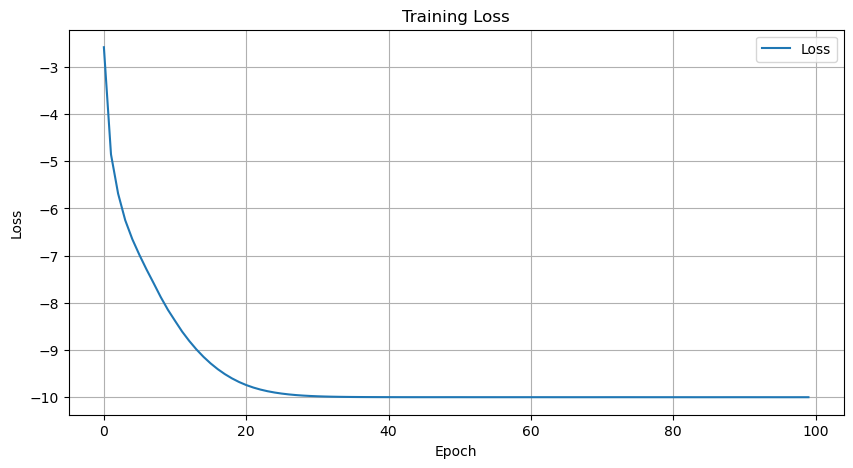

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


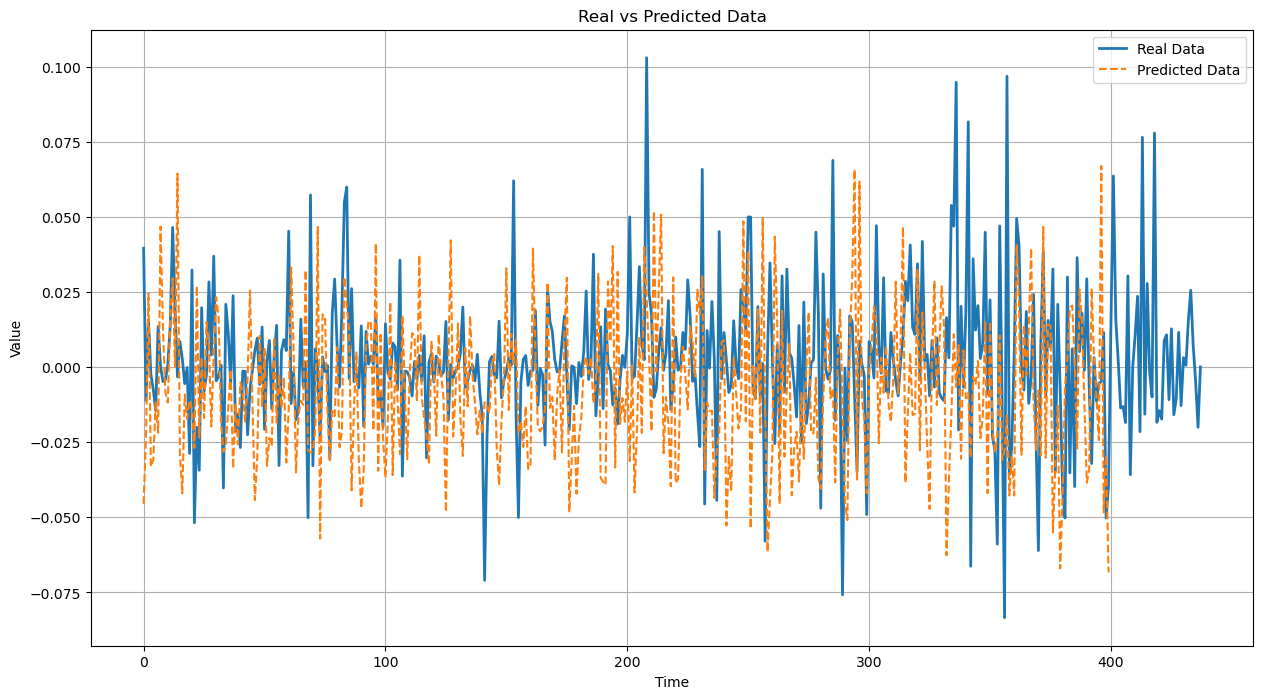

Stats length: 0
Stats: []
No statistics to plot
Detected change points for BTC-USD: []


In [96]:
# Функции для вычисления сходства и потерь
from tensorflow.keras import backend as K

cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)


# Пример использования
crypto_data = crypto_values.copy()
crypto_data.set_index('Date', inplace=True)

# Разделение данных на обучающую и тестовую выборки
train_data, test_data = train_test_split(crypto_data, test_size=0.2, shuffle=False)

# Обработка данных для обучения
train_data = train_data.values[:-(train_data.shape[0] % 100)].reshape(-1, 100, 1)

# Инициализация и обучение модели
input_shape = (100, 1)
n_steps = 100
code_size = 10
model = get_TCN_encoder(input_shape, n_steps, code_size)
train_model(model, train_data, _cosine_simililarity_dim1, contrastive_loss_fn, epochs=100)

# Применение модели для детекции точек разрыва на тестовых данных
selected_coin = 'BTC-USD'
real_data = test_data[selected_coin].values
real_data = real_data[:-(real_data.shape[0] % 100)]
real_data_reshaped = real_data.reshape(-1, 100, 1)
predicted_data = model.predict(real_data_reshaped).flatten()
visualize_predictions(test_data[selected_coin].values, predicted_data)

detected_change_points = detect_change_points(test_data[selected_coin].values, model, threshold=0.0002)
print(f'Detected change points for {selected_coin}: {detected_change_points}')



 10%|█         | 1/10 [00:01<00:10,  1.19s/it]

Epoch [1/10], Loss: 0.0018


 20%|██        | 2/10 [00:02<00:09,  1.19s/it]

Epoch [2/10], Loss: 0.0013


 30%|███       | 3/10 [00:03<00:08,  1.19s/it]

Epoch [3/10], Loss: 0.0013


 40%|████      | 4/10 [00:04<00:07,  1.19s/it]

Epoch [4/10], Loss: 0.0013


 50%|█████     | 5/10 [00:05<00:05,  1.17s/it]

Epoch [5/10], Loss: 0.0013


 60%|██████    | 6/10 [00:06<00:04,  1.10s/it]

Epoch [6/10], Loss: 0.0013


 70%|███████   | 7/10 [00:07<00:03,  1.03s/it]

Epoch [7/10], Loss: 0.0013


 80%|████████  | 8/10 [00:08<00:02,  1.02s/it]

Epoch [8/10], Loss: 0.0013


 90%|█████████ | 9/10 [00:09<00:01,  1.01s/it]

Epoch [9/10], Loss: 0.0013


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

Epoch [10/10], Loss: 0.0013


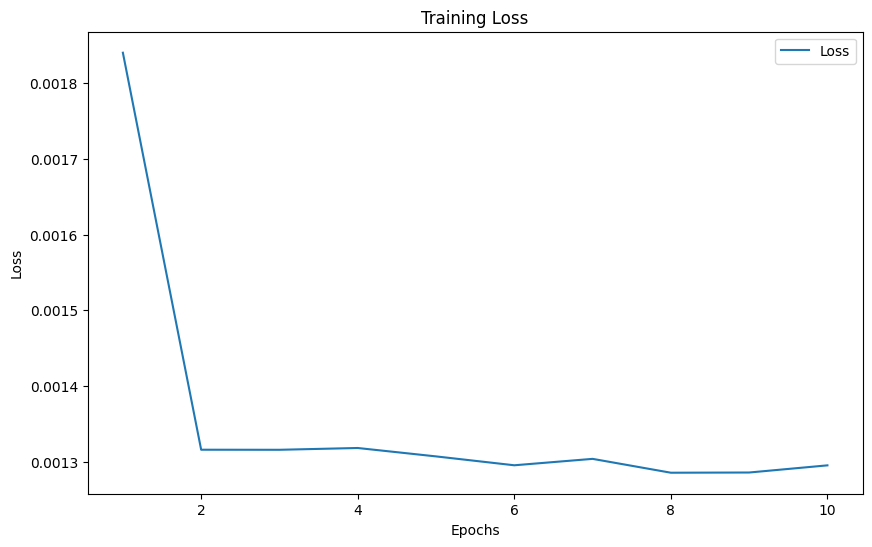

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class CPCModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CPCModel, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.predictor = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        encoded, _ = self.encoder(x)
        predictions = self.predictor(encoded[:, -1, :])  # Используем только последний временной шаг
        return predictions

def create_dataloader(series, window_size, batch_size):
    X = []
    y = []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)  # reshape y to match the output dimension
    dataset = TensorDataset(torch.Tensor(X), torch.Tensor(y))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

def train_cpc(model, dataloader, epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    loss_values = []
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for inputs, targets in dataloader:
            inputs = inputs.unsqueeze(-1)  # добавляем измерение для input_dim
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(dataloader)
        loss_values.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')
    return model, loss_values

# Параметры модели и данные
input_dim = 1
hidden_dim = 64
output_dim = 1
window_size = 30
batch_size = 16
epochs = 10
learning_rate = 0.001

# Создание DataLoader
dataloader = create_dataloader(df_with_change_points['price'].values, window_size, batch_size)

# Обучение модели CPC
model = CPCModel(input_dim, hidden_dim, output_dim)
trained_model, loss_values = train_cpc(model, dataloader, epochs, learning_rate)

# Визуализация loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


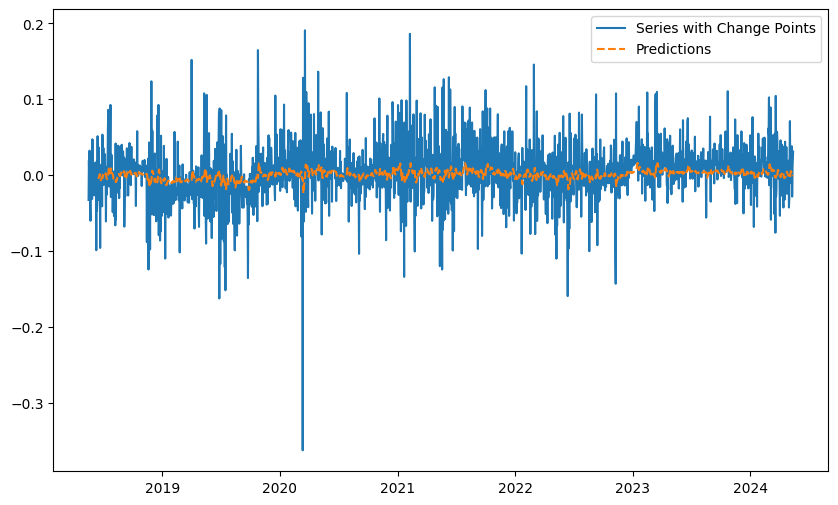

In [43]:
# Использование модели для детекции точек разрыва
model.eval()
with torch.no_grad():
    series = df_with_change_points['price'].values
    inputs = []
    for i in range(len(series) - window_size):
        inputs.append(series[i:i + window_size])
    inputs = torch.Tensor(inputs).unsqueeze(-1)  # добавляем измерение для input_dim
    predictions = model(inputs).squeeze().numpy()

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(df_with_change_points['date'], df_with_change_points['price'], label='Series with Change Points')
plt.plot(df_with_change_points['date'][window_size:], predictions, label='Predictions', linestyle='--')
plt.legend()
plt.show()


 10%|█         | 1/10 [01:36<14:29, 96.58s/it]

Epoch [1/10], Loss: 24.0416


 20%|██        | 2/10 [03:17<13:10, 98.87s/it]

Epoch [2/10], Loss: 1.7768


 30%|███       | 3/10 [04:49<11:11, 95.87s/it]

Epoch [3/10], Loss: 1.6692


 40%|████      | 4/10 [06:20<09:24, 94.03s/it]

Epoch [4/10], Loss: 1.6612


 50%|█████     | 5/10 [07:53<07:48, 93.69s/it]

Epoch [5/10], Loss: 1.6577


 60%|██████    | 6/10 [09:20<06:05, 91.36s/it]

Epoch [6/10], Loss: 1.6309


 70%|███████   | 7/10 [10:48<04:30, 90.13s/it]

Epoch [7/10], Loss: 1.6117


 80%|████████  | 8/10 [12:17<03:00, 90.03s/it]

Epoch [8/10], Loss: 1.5986


 90%|█████████ | 9/10 [13:44<01:28, 88.95s/it]

Epoch [9/10], Loss: 1.6426


100%|██████████| 10/10 [15:09<00:00, 90.97s/it]

Epoch [10/10], Loss: 1.5912


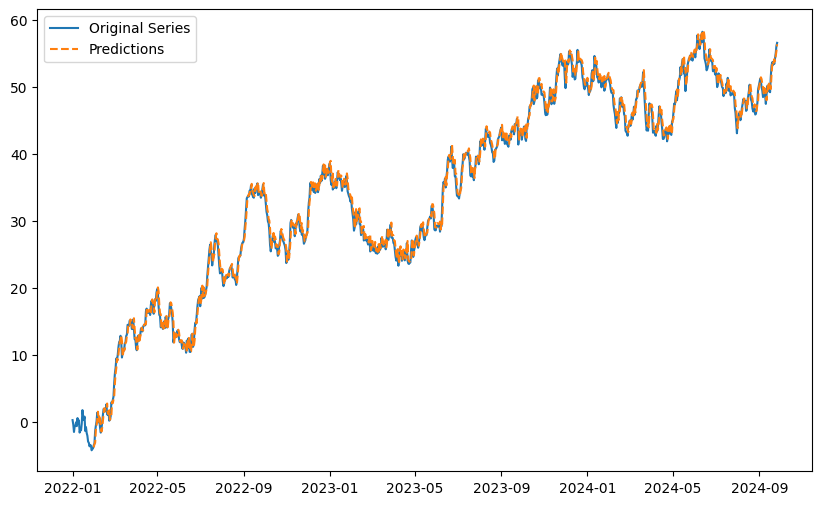

In [45]:
# Генерация синтетических данных для 250 рядов
num_series = 250
all_series = []

for _ in range(num_series):
    dates = pd.date_range(start='2022-01-01', periods=1000, freq='D')
    prices = np.cumsum(np.random.normal(loc=0, scale=1, size=1000))
    df = pd.DataFrame({'date': dates, 'price': prices})
    df_with_change_points, _ = add_synthetic_change_points(df, 'price', num_change_points)
    all_series.append(df_with_change_points['price'].values)

# Создание DataLoader для 250 рядов
def create_combined_dataloader(series_list, window_size, batch_size):
    X = []
    y = []
    for series in series_list:
        for i in range(len(series) - window_size):
            X.append(series[i:i + window_size])
            y.append(series[i + window_size])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    dataset = TensorDataset(torch.Tensor(X), torch.Tensor(y))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

combined_dataloader = create_combined_dataloader(all_series, window_size, batch_size)

# Обучение модели CPC на 250 рядах
model = CPCModel(input_dim, hidden_dim, output_dim)
trained_model, loss_values = train_cpc(model, combined_dataloader, epochs, learning_rate)

# Детекция Change Points на исходных данных
original_series = df['price'].values  # замените на ваш исходный ряд
with torch.no_grad():
    inputs = []
    for i in range(len(original_series) - window_size):
        inputs.append(original_series[i:i + window_size])
    inputs = torch.Tensor(inputs).unsqueeze(-1)
    original_predictions = model(inputs).squeeze().numpy()

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['price'], label='Original Series')
plt.plot(df['date'][window_size:], original_predictions, label='Predictions', linestyle='--')
plt.legend()
plt.show()


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Пример расчета метрик (предполагается, что у вас есть истинные метки change_points и предсказанные model_change_points)
true_change_points = np.zeros(len(df_with_change_points))
true_change_points[change_points] = 1

predicted_change_points = np.zeros(len(df_with_change_points))
threshold = 0.001
predicted_change_points[np.where(predictions > threshold)] = 1  # threshold нужно подобрать

precision = precision_score(true_change_points, predicted_change_points)
recall = recall_score(true_change_points, predicted_change_points)
f1 = f1_score(true_change_points, predicted_change_points)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Precision: 0.00
Recall: 0.10
F1 Score: 0.01


### Реализация вдохновлённая гитхабом

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Обработка данных для обучения
def prepare_data(data, window_size):
    data = data.values.astype(np.float32)
    n = len(data)
    remainder = n % window_size
    if remainder != 0:
        padding = window_size - remainder
        data = np.pad(data, (0, padding), 'constant', constant_values=0)
    return data.reshape(-1, window_size, 1)

# Модель TCN
def get_TCN_encoder(input_shape, code_size):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(input_layer)
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    output_layer = layers.Dense(code_size)(x)
    return models.Model(input_layer, output_layer)

# Функции потерь и сходства
def cosine_similarity_dim1(x, y):
    x_normalized = x / tf.norm(x, axis=1, keepdims=True)
    y_normalized = y / tf.norm(y, axis=1, keepdims=True)
    sim = tf.matmul(x_normalized, y_normalized, transpose_b=True)
    return sim

def contrastive_loss_fn(history, future, similarity, temperature=0.1):
    sim = similarity(history, future)
    pos_sim = tf.linalg.tensor_diag_part(sim)
    neg_sim = tf.reduce_sum(sim, axis=-1) - pos_sim
    pos_sim = K.exp(pos_sim / temperature)
    neg_sim = K.exp(neg_sim / temperature)
    loss = -tf.reduce_mean(tf.math.log(pos_sim / (pos_sim + neg_sim)))
    return loss

# Обучение модели
def train_model(model, train_data, similarity_fn, loss_fn, epochs=100, batch_size=64, learning_rate=1e-4, temperature=0.1):
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    history = []

    num_batches = (len(train_data) // batch_size) * batch_size

    for epoch in tqdm(range(epochs), desc="Training"):
        epoch_loss = 0
        for start in range(0, num_batches, batch_size):
            batch = train_data[start:start+batch_size]
            with tf.GradientTape() as tape:
                y_pred = model(batch, training=True)
                y_pred_flattened = tf.reshape(y_pred, [batch.shape[0], -1])  # Обеспечить согласованность форм
                batch_flattened = tf.reshape(batch, [batch.shape[0], -1])  # Обеспечить согласованность форм
                loss = loss_fn(batch_flattened, y_pred_flattened, similarity_fn, temperature)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            epoch_loss += loss.numpy()
        history.append(epoch_loss / (num_batches // batch_size))

    plt.figure(figsize=(10, 5))
    plt.plot(history, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Детекция точек разладки
def estimate_CPs(sim, threshold=0.5):
    est_cp = np.zeros(sim.shape[0])
    est_cp[np.where(sim < threshold)[0]] = 1
    return est_cp

def detect_change_points(data, model, window_size=100, threshold=0.5):
    data_length = len(data)
    change_points = []
    stats = []

    for i in range(window_size, data_length - window_size):
        window = data[i-window_size:i+window_size]
        if window.shape[0] == window_size:
            window = window.reshape(1, -1, 1)
            pred = model.predict(window)
            stats.append(pred[0])

    stats = np.array(stats)
    change_points = estimate_CPs(stats, threshold=threshold)

    plt.figure(figsize=(15, 8))
    plt.plot(data, label='Real Data', linewidth=2)
    plt.plot(range(window_size, data_length - window_size), stats, label='Predicted Statistics', linestyle='--')
    for cp in np.where(change_points == 1)[0]:
        plt.axvline(cp + window_size, color='red', linestyle='--', alpha=0.5, label='Detected Change Point' if cp == np.where(change_points == 1)[0][0] else "")
    plt.title('Change Point Detection')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    return change_points

# Визуализация предсказаний
def visualize_predictions(real_data, predicted_data):
    plt.figure(figsize=(15, 8))
    plt.plot(real_data, label='Real Data', linewidth=2)
    plt.plot(predicted_data, label='Predicted Data', linestyle='--', alpha=0.7)
    plt.title('Real vs Predicted Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [48]:
crypto_data = crypto_values.copy()
crypto_data.set_index('Date', inplace=True)
crypto_data = crypto_data.iloc[:,1:]

# Разделение данных на обучающую, тестовую и валидационную выборки
train_data, temp_data = train_test_split(crypto_data, test_size=0.4, shuffle=False)
test_data, val_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

window_size = 100
train_data = prepare_data(train_data, window_size)
test_data = prepare_data(test_data, window_size)
val_data = prepare_data(val_data, window_size)

# Обучение модели
input_shape = (window_size, 1)
code_size = 10
model = get_TCN_encoder(input_shape, code_size)
train_model(model, train_data, cosine_similarity_dim1, contrastive_loss_fn, epochs=100)

# Применение модели для детекции точек разрыва на тестовых данных
selected_coin = 'BTC-USD'
real_data = test_data[selected_coin].values
real_data = real_data[:-(real_data.shape[0] % window_size)]
real_data_reshaped = real_data.reshape(-1, window_size, 1).astype(np.float32)
predicted_data = model.predict(real_data_reshaped).flatten()
visualize_predictions(test_data[selected_coin].values, predicted_data)

detected_change_points = detect_change_points(test_data[selected_coin].values, model, threshold=0.0002)
print(f'Detected change points for {selected_coin}: {detected_change_points}')



Training:   0%|          | 0/100 [00:00<?, ?it/s]


InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [64,100], In[1]: [64,10] [Op:MatMul] name: 